# Analysis of Public Comments Regarding the EPA's Revised Definition of "Waters of the United States" (WOTUS)

Simplified code for NH-Python presentation

## <a name="library-imports"></a>Library Imports

In [1]:
# Standard imports
import os
import pickle
import re
import sys
import warnings
warnings.filterwarnings('ignore', 'DeprecationWarning') 

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Sklearn pre-processing, utilities, and metrics imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import normalize, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics
from sklearn.utils import resample

# Sklearn model imports
from sklearn.decomposition import LatentDirichletAllocation as LDA, NMF, PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [3]:
# Other imports from PIP
import spacy
from xgboost import XGBClassifier

In [4]:
# Get color codes from Seaborn palette for charts
pal = sns.color_palette('muted')
hex_list = pal.as_hex()

blue_hexcode = hex_list[-1]
red_hexcode = hex_list[3]
gray_hexcode = hex_list[7]

## <a name="data-cleaning"></a>Data Cleaning and Helper Functions

In [5]:
full_df = pd.read_pickle('../Data/full_labeled.pkl')

full_df.head()

,Document Title,Document ID,Posted Date,Received Date,Document SubType,Post Mark Date,Document Detail,Comment,Support_Rule_Change
0,Anonymous public comment,EPA-HQ-OW-2018-0149-6689,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...,0.0
1,Anonymous public comment,EPA-HQ-OW-2018-0149-6688,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...,0.0
2,Anonymous public comment,EPA-HQ-OW-2018-0149-7377,2019-05-01,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please abandon this proposed rollback of the 2...,0.0
3,Anonymous public comment,EPA-HQ-OW-2018-0149-6707,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,"My husband and I have two wonderful daughters,...",0.0
4,Comment submitted by T. Dahlin,EPA-HQ-OW-2018-0149-7983,2019-05-01,2019-04-12,Public Comment,04/12/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please do not change the definitions within th...,0.0


In [6]:
# Segment comments and labels, drop duplicate comments, remove comment box artifacts
comments = full_df.loc[:, ['Comment', 'Support_Rule_Change']]
print('BEFORE:')
print(comments.loc[5993, 'Comment'])

comments.drop_duplicates(['Comment'], inplace=True)

comments['Comment'] = comments['Comment'].apply(lambda s: s.replace('PLEASE WRITE YOUR COMMENT HERE:', ''))
print('AFTER:')
print(comments.loc[5993, 'Comment'])

BEFORE:
PLEASE WRITE YOUR COMMENT HERE:  It is my wish and request that the Waters of the United States regulation be repealed. Regards, Thomas Moore
AFTER:
  It is my wish and request that the Waters of the United States regulation be repealed. Regards, Thomas Moore


In [7]:
comments.head()

,Comment,Support_Rule_Change
0,I write to express my opposition to the Enviro...,0.0
1,I write to express my opposition to the Enviro...,0.0
2,Please abandon this proposed rollback of the 2...,0.0
3,"My husband and I have two wonderful daughters,...",0.0
4,Please do not change the definitions within th...,0.0


In [8]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7986 entries, 0 to 8186
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Comment              7986 non-null   object 
 1   Support_Rule_Change  1200 non-null   float64
dtypes: float64(1), object(1)
memory usage: 507.2+ KB


In [9]:
# Fill unlabeled comments with -1
comments.fillna(value=-1, axis=1, inplace=True)
comments.tail()

,Comment,Support_Rule_Change
8182,I object to the proposed changes. We NEED all ...,0.0
8183,I am 39 years old and thanks to the hard work ...,0.0
8184,I pray that EPA leadership come to the underst...,-1.0
8185,clean water is one of the absolute necesseties...,-1.0
8186,The Clean Water Rule provides clear protection...,0.0


In [10]:
# Split ALL comments into training and test sets. The X_train set,
#    (all training comments including unlabeled ones), will be used
#    for unsupervised techniques
X = comments.drop('Support_Rule_Change', axis=1)
y = comments['Support_Rule_Change']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6388, 1) (1598, 1) (6388,) (1598,)


In [11]:
# Create labeled-only sets from training and test sets to be
#    used in exploratory analysis and supervised learning
X_labeled_train = X_train[y_train != -1]
y_labeled_train = y_train[y_train != -1]

X_labeled_test = X_test[y_test != -1]
y_labeled_test = y_test[y_test != -1]

print(X_labeled_train.shape, y_labeled_train.shape, X_labeled_test.shape, y_labeled_test.shape)

(960, 1) (960,) (240, 1) (240,)


In [12]:
# Percent / breakdown of the labeled comments
print(f'Percent supportive labeled comments: {np.mean(y_labeled_train)*100}%')
y_labeled_train.value_counts()

Percent supportive labeled comments: 20.3125%


0.0    765
1.0    195
Name: Support_Rule_Change, dtype: int64

In [13]:
# Training sets by sentiment (for resampling)
support_train = X_labeled_train[y_labeled_train == 1]
oppose_train = X_labeled_train[y_labeled_train == 0]

## <a name="data-preprocessing"></a>Data Pre-Processing

### Bag of Words (BOW)

In [14]:
# Create custom tokenizer/lemmatizer for bag-of-words approach
nlp_sm = spacy.load('en_core_web_sm', disable=['tagger', 'parser', 'ner'])

def spacy_tokenizer(doc):
    """
    Applies spaCy's built-in tokenizer pipeline capabilities to
        to keep a lemmatized version of each token for alpha-
        numeric word's only (excludes punctuation and whitespace)
    :param doc: string
    :return: list of lemmatized tokens found in `doc`
    """
    tokens = nlp_sm(doc)
    return([token.lemma_ for token in tokens
            if token.lemma_.isalnum()])

In [15]:
# Import SpaCy tokenizer to get around joblib pickling
#    issue when using it within GridSearchCV. Work-around source:
#    https://stackoverflow.com/questions/53885198/using-spacy-as-tokenizer-in-sklearn-pipeline
# from Tokenizer.tokenizer import external_spacy_tokenizer

In [16]:
# Test the lemmatizer
spacy_tokenizer('accomplish, accomplishes, accomplished, accompilsh')

['accomplish', 'accomplish', 'accomplish', 'accompilsh']

In [17]:
# Stop words (need to lemmatize to match tokenized words)
stop_words = list(nlp_sm.Defaults.stop_words)
tokenized_stop_words = spacy_tokenizer(' '.join(stop_words))

print(len(stop_words))
print(stop_words[:20])

326
['behind', 'or', 'whatever', 'eight', 'among', 'n‘t', 'about', '‘m', 'which', 'somehow', 'everything', 'elsewhere', 'somewhere', 'empty', 'wherever', 'otherwise', 'bottom', 'below', 're', 'perhaps']


In [18]:
# Create term-document matrix using a count vectorizer
count_vec = CountVectorizer(tokenizer=spacy_tokenizer,
                            stop_words=tokenized_stop_words,
                            max_df=0.90,
                            min_df=5)

count_data = count_vec.fit_transform(X_train['Comment'])
print(count_data.shape)

vocab = np.array(count_vec.get_feature_names())

(6388, 4143)


In [19]:
s = 160
print(vocab[s:s+100])

['accompany' 'accomplish' 'accord' 'accordance' 'accordingly' 'account'
 'accountability' 'accountable' 'accumulate' 'accurate' 'ace' 'acequias'
 'achieve' 'acid' 'acknowledge' 'acre' 'acreage' 'act' 'action' 'active'
 'actively' 'activist' 'activity' 'actual' 'actually' 'acutely' 'adam'
 'adamantly' 'adapt' 'add' 'addition' 'additional' 'additionally'
 'address' 'adequate' 'adequately' 'adhere' 'adjacency' 'adjacent'
 'adjoin' 'admin' 'administer' 'administration' 'administrative'
 'administrator' 'admit' 'adopt' 'adoption' 'adult' 'advance' 'advantage'
 'adverse' 'adversely' 'advice' 'advise' 'advisory' 'advocacy' 'advocate'
 'aesthetic' 'affair' 'affect' 'afford' 'affordable' 'affront' 'afraid'
 'africa' 'afternoon' 'ag' 'age' 'agency' 'agencyadministrator'
 'agencyepa' 'agencys' 'agenda' 'agendum' 'agent' 'aggregate' 'aggressive'
 'ago' 'agree' 'agreement' 'agribusiness' 'agricultural' 'agriculture'
 'ahead' 'aid' 'aim' 'air' 'aka' 'akin' 'al' 'alabama' 'alan' 'alarm'
 'alaska' 'al

In [20]:
# Create term-document matrix using TF-IDF vectorizer
tf_vec = TfidfVectorizer(tokenizer=spacy_tokenizer,
                         stop_words=tokenized_stop_words,
                         max_df=0.90,
                         min_df=5)

tf_data = tf_vec.fit_transform(X_train['Comment'])
print(tf_data.shape)

vocab_tf = np.array(tf_vec.get_feature_names())

(6388, 4143)


### Document Vectors

In [21]:
# Load large language model (to access pre-trained word vectors)
nlp_lg = spacy.load('en_core_web_lg',
                    disable=['tagger', 'parser', 'ner'])

In [22]:
# Create document vector matrix using SpaCy word vectors
#   from the large language model
doc_vecs = pd.DataFrame([nlp_lg(text).vector for text in comments['Comment']],
                        index=comments.index,
                        columns=['Vec_{}'.format(i) for i in range(1, 301)])
doc_vecs.shape

(7986, 300)

In [23]:
# Check that indices match
np.all(X.index == doc_vecs.index)

True

In [24]:
# Extract full and labeled train and test sets
doc_vec_train = doc_vecs.loc[X_train.index]
doc_vec_test = doc_vecs.loc[X_test.index]
doc_labeled_train = doc_vecs.loc[X_labeled_train.index]
doc_labeled_test = doc_vecs.loc[X_labeled_test.index]

print(doc_vec_train.shape, doc_vec_test.shape,
      doc_labeled_train.shape, doc_labeled_test.shape)

(6388, 300) (1598, 300) (960, 300) (240, 300)


In [25]:
# Function to apply word vectors to comments
#    within an sklearn pipeline
def get_word_vectors(X):
    """
    Applies SpaCy's language model to each comment in sequence
        X to find the average of the model's pre-trained word
        vectors for each comment
    :param X: sequence of string(s)
    :returns: an mX300-dimensional matrix with average word
        vector values
    """
    return np.array([nlp_lg(c).vector for c in X])

In [26]:
# Test a sample pipeline
wordvec_pipe = Pipeline([('wordvecs', FunctionTransformer(get_word_vectors, validate=False))])

wordvec_pipe.fit_transform(X_train.head()['Comment']).shape

(5, 300)

## <a name="clustering-analysis"></a>Clustering Analysis

In [27]:
# Instantiate vectorizers
n_feats = 4000
titles = ['Count', 'HashL2', 'HashTFIDF', 'TFIDF']

# Count vectorizer
vect_count = CountVectorizer(tokenizer=spacy_tokenizer,
                             stop_words=tokenized_stop_words,
                             min_df=5)

# Hashing vectorizer using L2 norm
vect_hash_L2 = HashingVectorizer(tokenizer=spacy_tokenizer,
                                 stop_words=tokenized_stop_words,
                                 n_features=n_feats,
                                 norm='l2')

# Hashing vectorizer normalized using TF-IDF
hashy = HashingVectorizer(tokenizer=spacy_tokenizer,
                          stop_words=tokenized_stop_words,
                          n_features=n_feats,
                          norm=None)

vect_hash_tfidf = make_pipeline(hashy, TfidfTransformer())

# TF-IDF vectorizer
vect_tfidf = TfidfVectorizer(tokenizer=spacy_tokenizer,
                             stop_words=tokenized_stop_words,
                             min_df=5)

all_vects = [vect_count, vect_hash_L2, vect_hash_tfidf, vect_tfidf]

In [28]:
# Collect metrics for all BOW vectorizers for different number of clusters
#   Long runtime! Change model to MiniBatchKMeans for faster performance

# Choose model with MINI - True: MiniBatchKMeans; False: KMeans
MINI = True

n_clusters = list(range(2, 13))
km_inertias = {t: [] for t in titles}
km_silhouettes = {t: [] for t in titles}

for title, vect in zip(titles, all_vects):
    _X = vect.fit_transform(X_train['Comment'])
    for n in n_clusters:
        if MINI:
            model = MiniBatchKMeans(n_clusters=n,
                                    n_init=1,
                                    init_size=1000,
                                    batch_size=1000)
        else:
            model = KMeans(n_clusters=n,
                           max_iter=100,
                           n_init=1,
                           n_jobs=-1)
        
        model.fit(_X)
        km_inertias[title].append(model.inertia_)
        km_silhouettes[title].append(metrics.silhouette_score(_X, model.labels_, sample_size=1000))

/Users/heatherkusmierz/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/Users/heatherkusmierz/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [29]:
# Create key for word vector model
new_t = 'WordVec'
titles.append(new_t)
km_inertias[new_t] = []
km_silhouettes[new_t] = []

In [30]:
# Collect metrics for word vector-based clustering
for n in n_clusters:
    if MINI:
        model = MiniBatchKMeans(n_clusters=n,
                                n_init=1,
                                init_size=1000,
                                batch_size=1000)
    else:
        model = KMeans(n_clusters=n,
                       max_iter=100,
                       n_init=1,
                       n_jobs=-1)
        
    model.fit(doc_vec_train)
    km_inertias[new_t].append(model.inertia_)
    km_silhouettes[new_t].append(metrics.silhouette_score(doc_vec_train.values, model.labels_, sample_size=1000))

In [33]:
def plot_cluster_scores(title, inertias, silhouettes):
    """
    Create side-by-side line charts of inertia and silhouette scores for
        clustering model and saves the figure
    :param title: str, the type of vectorizer for the chart title and saved
        file name
    :param inertias: list of inertia scores run over range of clusters
    :param silhouettes: list of silhouette scores run over range of clusters
    :return: None
    """
    plt.subplots(1, 3, figsize=(20, 6))
    clusters = list(range(2, len(inertias) + 2))
    i_x_c = np.array(inertias) * clusters
    
    # Cluster-inertia plot
    plt.subplot(1, 3, 1)
    plt.plot(clusters, inertias, 'o--', c=blue_hexcode)
    plt.xticks(clusters)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia Score')
    plt.title('{}: Inertia Score by Cluster Count\n'
              '{} Vectorizer'
              .format('MiniBatchKMeans' if MINI else 'KMeans', title));
    
    # Cluster-inertia * no. of clusters plot
    plt.subplot(1, 3, 2)
    plt.plot(clusters, i_x_c, 'o--', c=gray_hexcode)
    plt.xticks(clusters)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia Score Times No. of Clusters')
    plt.title('{}: Inertia Score * Cluster by Cluster Count\n'
              '{} Vectorizer'
              .format('MiniBatchKMeans' if MINI else 'KMeans', title));

    # Cluster-silhouette score plot
    plt.subplot(1, 3, 3)
    plt.plot(clusters, silhouettes, 'o--', c=red_hexcode)
    plt.xticks(clusters)
    plt.ylim((0, 1))
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('{}: Silhouette Score by Cluster Count\n'
              '{} Vectorizer'
              .format('MiniBatchKMeans' if MINI else 'KMeans', title));

#     plt.savefig('./Figures/{}_{}_Inertia-Silhouette.png'
#                 .format('MiniBatchKMeans' if MINI else 'KMeans', title));
    plt.show()

In [34]:
# Plot metrics for all vectorizers
# for title in titles:
#     plot_cluster_scores(title,
#                         km_inertias[title],
#                         km_silhouettes[title])

### Summary of Clustering Metrics

**Inertia** calculates the sum of the squared distances between data points and their nearest cluster. Low overall values of inertia are generally better, but it will naturally favor having more clusters. In the below charts, the middle one shows the inertia score scaled by the number of clusters to adjust for this. A drop to inertia with an additional cluster needs to outpace the cost of adding that cluster - the minimum value can help identify the optimal number of clusters.

**Silhouette score** uses two scores to find the mean distance between each observation and all others - both in the same cluster and then in the nearest cluster. Values range from -1 to 1, where a score of 1 indicates the point is close to others in the same cluster, but far away from the next cluster over. A score near -1 indicates the point is not near ones in its cluster but close to the next nearest cluster. And a score of 0 indicates overlapping clusters, where an observation is close to the decision boundary. A score closest to 1 is ideal, as that indicates tight, highly separable clusters.

The KMeans algorithm was run with four different bag-of-words (BOW) pre-processing applications and one based on pre-trained word vectors. It also checked performance using unigrams only vs. also including bigrams. Including bigrams did not generally improve the metrics, therefore the charts weren't included below.

1) **BOW: Count Vectorizer**

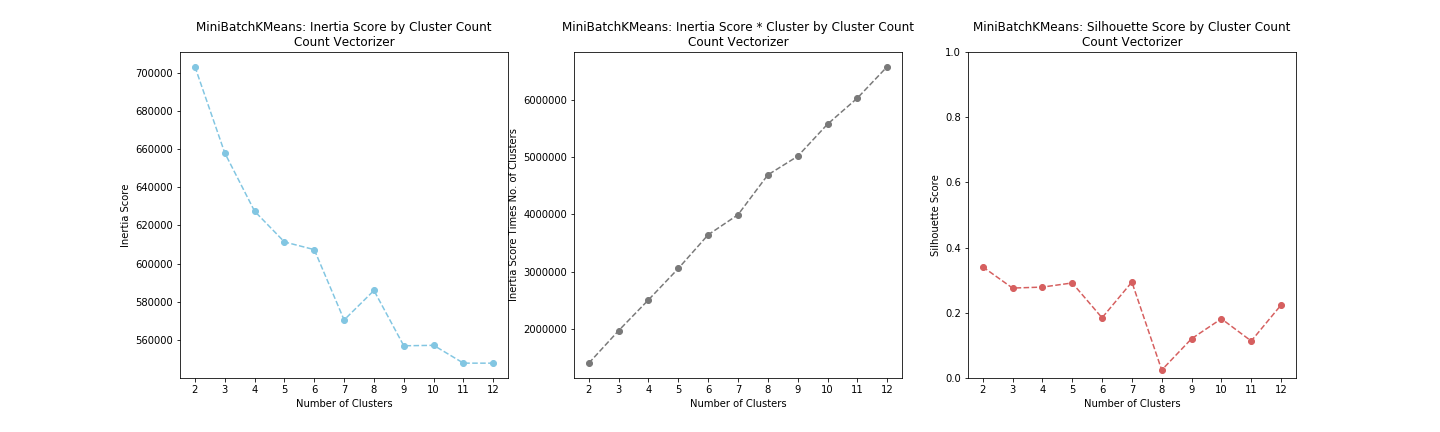

The count vectorizer plots had inertia values that were a factor of over a hundred times higher than all the others, which is why the `y` scale wasn't pegged for them, likely due to the fact those values weren't normalized in any way. It managed the highest overall silhouette scores, though, with the peak value over 0.3 at two clusters.

2) **BOW: Hashing Vectorizer with L2 Norm**

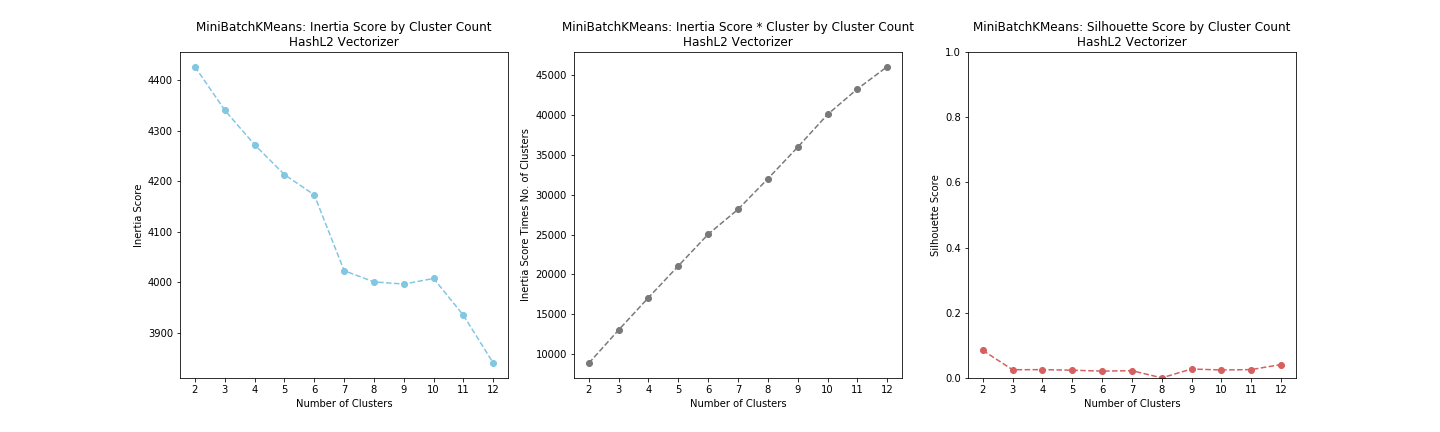

This method had the second-lowest overall inertia values, but similar silhouette scores as the remaining options around 0.0-0.1.

While the inertia score is the highest (worst) for two clusters, the peak silhouette score favors two clusters. Unfortunately, the silhouette scores are very close to zero, indicating a high degree of overlapping clusters.

3) **BOW: Hashing Vectorizer Normalized using TF-IDF**

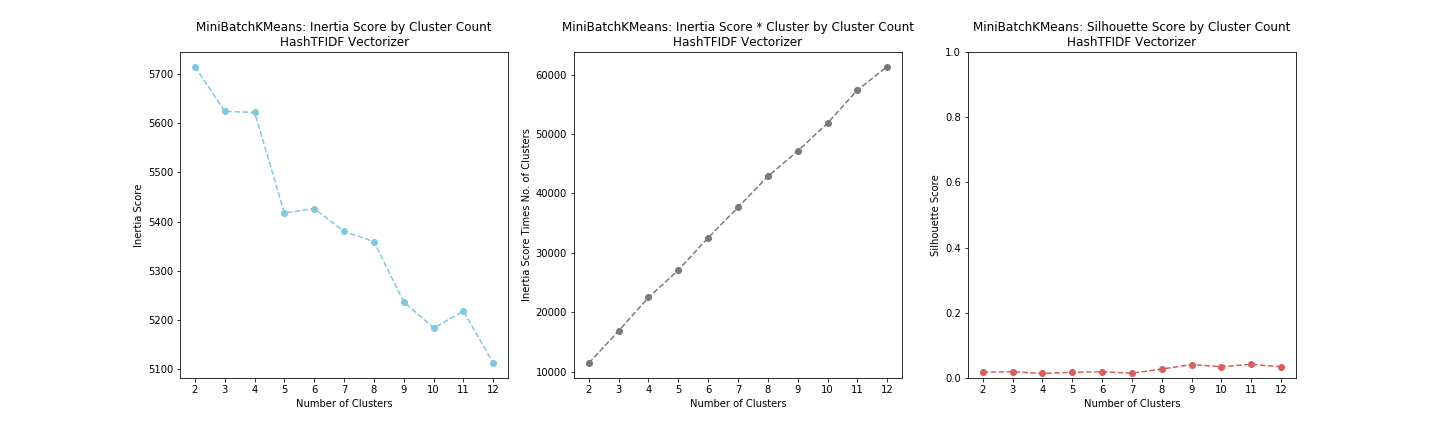

Although a little hard to see given the scale, this analysis shows a story that supports nine to eleven clusters. That range of cluster counts have near-minimum inertia values as well as slightly elevated silhouette scores. However, the overall inertia and silhouette values are worse than the previous analysis using a hashing vectorizer with an L2 norm. The inertia scores are all higher, and the silhouette scores hover around the same range.

4) **BOW: TF-IDF Vectorizer**

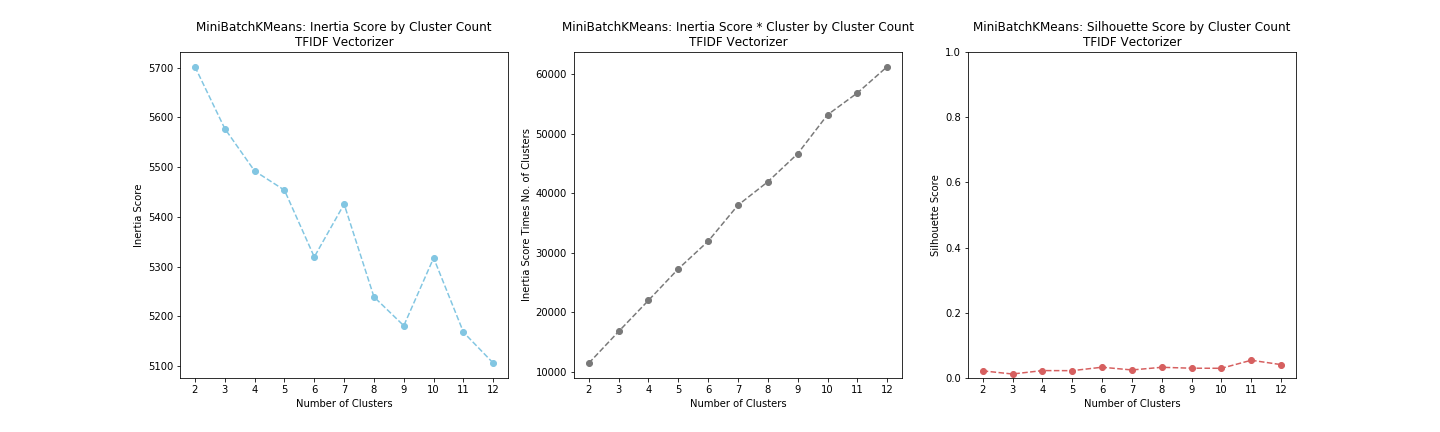

Not surprisingly, this analysis is very similar to the hashing vectorizer with TF-IDF normalization. The overall score values are in line with where they fell out in the other TF-IDF-based analysis. There's no clear optimal number of clusters in these charts, and the silhouette scores seem to continue to climb at the limit of twelve clusters.

5) **Word Vectors**

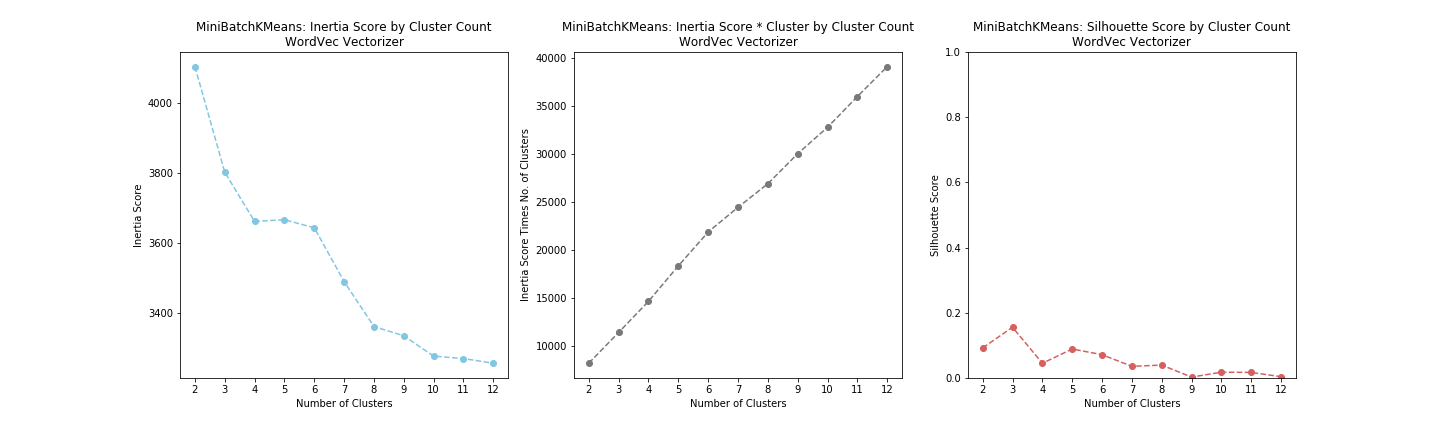

Instead of training on text pre-processed via a bag-of-words vectorizer, this model used SpaCy's pre-trained word vectors applied to each comment. (Word vectors are averaged for the entire document). The inertia scores are the lowest of the batch, and the silhouette scores fall in-between the ones using a count vectorizer and ones using the other BOW methods.

Analyzing the clusters will shed more light on how the models actually performed. For brevity, only the count vectorizer and word vector models will be used for this.

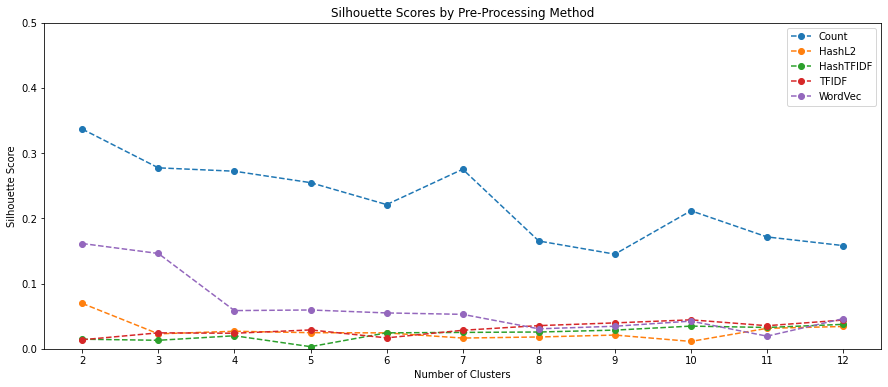

In [42]:
# Plot silhouette scores for all methods

plt.figure(figsize=(15, 6))
plt.title('Silhouette Scores by Pre-Processing Method')
plt.xlabel('Number of Clusters')
plt.xticks(n_clusters)
plt.ylabel('Silhouette Score')
plt.ylim((0, 0.5))

for title in titles:
    plt.plot(n_clusters, km_silhouettes[title], 'o--', label=title)

plt.legend();
# plt.savefig('./Figures/Clustering-AllSilhouetteScores.png')
plt.show()

In [43]:
# Create KMeans model with BOW count vectorizer, 2 clusters
X_data = vect_count.fit_transform(X_train['Comment'])
km_bowcount = KMeans(n_clusters=2,
                     max_iter=100,
                     n_init=1,
                     n_jobs=-1)

km_bowcount.fit(X_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=2, n_init=1, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [44]:
print('Inertia: {0: ,.0f}'.format(km_bowcount.inertia_))
print('Silhouette Coefficient: {0:.3f}'.format(
      metrics.silhouette_score(X_data, km_bowcount.labels_, sample_size=1000)))

Inertia:  697,447
Silhouette Coefficient: 0.319


In [48]:
# Create KMeans model with pre-trained word vectors, 2 clusters
km_wordvec = KMeans(n_clusters=2,
                    max_iter=100,
                    n_init=1,
                    n_jobs=-1)
        
km_wordvec.fit(doc_vec_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=2, n_init=1, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [49]:
print('Inertia: {0: ,.0f}'.format(km_wordvec.inertia_))
print('Silhouette Coefficient: {0:.3f}'.format(
      metrics.silhouette_score(doc_vec_train.values, km_wordvec.labels_, sample_size=1000)))

Inertia:  4,073
Silhouette Coefficient: 0.145


### Inspection of Comments in each Cluster - BOW Count Vectorizer Model

In [50]:
# Print comments from cluster 0
bow_cluster_0 = X_train[km_bowcount.labels_ == 0]

for idx, row in bow_cluster_0.head(15).iterrows():
    print(row['Comment'])
    print('\n----------\n')

The proposed rule would eliminate entire categories of waterways from the protections afforded by the Clean Water Act, threatening the water you use to drink, grow your food, fish, and recreate. Categories of excluded waterways include: interstate waters, ephemeral streams or other isolated waters, non-adjacent wetlands, ditches, upland waters, and groundwater.The proposed rule disproportionately impacts the western United States by eliminating the Clean Water Acts protections from most waterways and wetlands in New Mexico, Arizona and Nevada.The proposed rule undermines the science supporting an interconnected watershed approach to protect water quality and riparian habitat. More than half of waterways (60 percent) in the United States are ephemeralmeaning water only flows in these creeks or streams for a portion of the yearbut these waterways contribute significant flows and nutrients to our major rivers.In Arizona, New Mexico, Nevada, Utah, Colorado, and California ephemeral streams

In [51]:
# Print comments from cluster 1
bow_cluster_1 = X_train[km_bowcount.labels_ == 1]

for idx, row in bow_cluster_1.head(20).iterrows():
    print(row['Comment'])
    print('\n----------\n')

S. Waters- I live on the Rappahannock River. I'm concerned this proposed rule would remove protections that impact overall water quality. I rely on this as a source of my drinking water. All this could be harmed by the loss of federal protections. I ask the EPA to keep the Clean Water Act intact.

----------

economy.I am writing in hopes that my words will reach someone who cares about the health of people and life in general. I was shocked to hear the proposal to limit the Clean Water Act. My family & I live on a beautiful lake & regularly fish, swim & kayak in our lake & small streams. Why on earth would people even consider the polluting of our waterways to be acceptable? It just doesnt make any sense. There is obviously money involved. Someone stands to make a profit by allowing this change. This proposal to limit the Clean Water Act must be stopped. We must become better human beings, not worse. We must protect our natural resources if our planet & we are to survive. Regards, Jen

### Inspection of Comments in each Cluster - Word Vector Model

In [52]:
# Print comments from cluster 0
wv_cluster_0 = X_train[km_wordvec.labels_ == 0]

for idx, row in wv_cluster_0.head(15).iterrows():
    print(row['Comment'])
    print('\n----------\n')

The proposed rule would eliminate entire categories of waterways from the protections afforded by the Clean Water Act, threatening the water you use to drink, grow your food, fish, and recreate. Categories of excluded waterways include: interstate waters, ephemeral streams or other isolated waters, non-adjacent wetlands, ditches, upland waters, and groundwater.The proposed rule disproportionately impacts the western United States by eliminating the Clean Water Acts protections from most waterways and wetlands in New Mexico, Arizona and Nevada.The proposed rule undermines the science supporting an interconnected watershed approach to protect water quality and riparian habitat. More than half of waterways (60 percent) in the United States are ephemeralmeaning water only flows in these creeks or streams for a portion of the yearbut these waterways contribute significant flows and nutrients to our major rivers.In Arizona, New Mexico, Nevada, Utah, Colorado, and California ephemeral streams

In [53]:
# Print comments from cluster 1
wv_cluster_1 = X_train[km_wordvec.labels_ == 1]

for idx, row in wv_cluster_1.head(20).iterrows():
    print(row['Comment'])
    print('\n----------\n')

S. Waters- I live on the Rappahannock River. I'm concerned this proposed rule would remove protections that impact overall water quality. I rely on this as a source of my drinking water. All this could be harmed by the loss of federal protections. I ask the EPA to keep the Clean Water Act intact.

----------

economy.I am writing in hopes that my words will reach someone who cares about the health of people and life in general. I was shocked to hear the proposal to limit the Clean Water Act. My family & I live on a beautiful lake & regularly fish, swim & kayak in our lake & small streams. Why on earth would people even consider the polluting of our waterways to be acceptable? It just doesnt make any sense. There is obviously money involved. Someone stands to make a profit by allowing this change. This proposal to limit the Clean Water Act must be stopped. We must become better human beings, not worse. We must protect our natural resources if our planet & we are to survive. Regards, Jen

Both clustering models appear to have heavy overlap of comments opposing the rule change in their clusters. In spite of the metrics (somewhat) supporting a two-cluster model, they also showed overlap with silhouette scores of 0.16-0.32. A review of the cluster samples indicate that the clusters aren't separated by sentiment. Performing dimensionality reduction to create a visualization and overlaying a set of labeled comments will help illustrate the cluster separation better. This is done below with the count-vectorized feature set since that clustering model had the highest silhouette scores, indicating it had the tightest and most separable clusters.

### Dimensionality Reduction with PCA and TSNE to Visualize Clustering Performance

In [54]:
# Run analysis with either BOW Count data or Word Vec data
BOW = True

if BOW:
    dr_data = X_data.todense()  # PCA requires dense matrix vs sparse
    dr_labels = km_bowcount.labels_
else:
    dr_data = doc_vec_train
    dr_labels = km_wordvec.labels_

In [56]:
# Reduce dimensions with PCA
pca = PCA(n_components=20)
components = pca.fit_transform(dr_data)

print(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_)

[0.27489531 0.06505247 0.04723707 0.02961641 0.02483184 0.01647111
 0.01496524 0.01387008 0.01236698 0.01198625 0.01020695 0.00936387
 0.00815671 0.00765456 0.00731912 0.00713768 0.00660934 0.00639934
 0.00624471 0.00550586]


0.5858909034477688

In [57]:
components.shape

(6388, 20)

In [58]:
# Re-create DF with labeled clusters
col_names = ['PCA_{}'.format(i + 1) for i in range(pca.n_components_)]

pca_df = pd.DataFrame(components, columns=col_names, index=X_train.index)
pca_df['Cluster'] = dr_labels

pca_df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19,PCA_20,Cluster
5217,-2.851326,-0.100897,-0.156153,-0.509532,-0.051693,-0.574310,0.365761,1.348243,-0.312032,0.071220,-0.956665,-0.290243,-1.114665,1.628069,0.545517,-0.635007,-0.754554,0.462472,-0.735682,0.837703,1
1866,-3.053926,1.860213,0.638113,0.704271,-0.348808,-0.348976,-0.174673,0.210317,-0.467754,-0.306352,0.359530,-0.712886,0.136772,-0.772110,1.061270,-0.415268,-0.445979,-0.520096,0.365236,-0.282959,1
532,-6.309633,-0.062861,0.596124,0.084919,-0.418835,-0.362384,0.023243,0.256844,-0.147498,0.097564,0.163268,-0.142614,-0.050528,-0.274635,0.129249,0.232615,0.255598,0.248488,0.069551,-0.105294,1
5891,-5.608019,-0.260918,1.654925,0.352595,0.606026,-0.591460,1.378371,-0.413756,0.563181,-0.255191,0.868207,0.480361,0.569847,-0.639201,0.237367,0.616428,-0.471360,0.375007,-0.180914,0.146726,1
2514,7.733325,-2.180606,1.297884,0.359049,2.777592,-4.016842,5.750718,-5.743020,-4.562539,0.727530,-1.942403,2.410800,-1.275022,-1.753169,-1.069556,0.183118,-0.233259,-0.469323,-0.704621,0.094695,0


In [59]:
# Take sample of 100 supportive, 100 opposing comment labels
samp_0 = y_labeled_train[y_labeled_train == 0].sample(n=100,
                                                      replace=False,
                                                      random_state=42)

samp_1 = y_labeled_train[y_labeled_train == 1].sample(n=100,
                                                      replace=False,
                                                      random_state=42)
labels = pd.concat([samp_0, samp_1])

In [60]:
samples = pd.merge(labels, pca_df[['PCA_1', 'PCA_2']],
                   left_index=True,
                   right_index=True)

samples.tail(10)

,Support_Rule_Change,PCA_1,PCA_2
1166,1.0,-6.554713,-0.271418
8092,1.0,-5.703350,-0.470868
8160,1.0,5.981480,-1.396758
1099,1.0,-5.354149,-0.880168
2272,1.0,-0.630043,-1.697947
165,1.0,-6.459503,-0.376640
488,1.0,-1.318983,-0.718737
405,1.0,9.958242,-7.547318
22,1.0,-4.713412,0.097014
8133,1.0,3.790406,-2.399289


In [61]:
samples.shape

(200, 3)

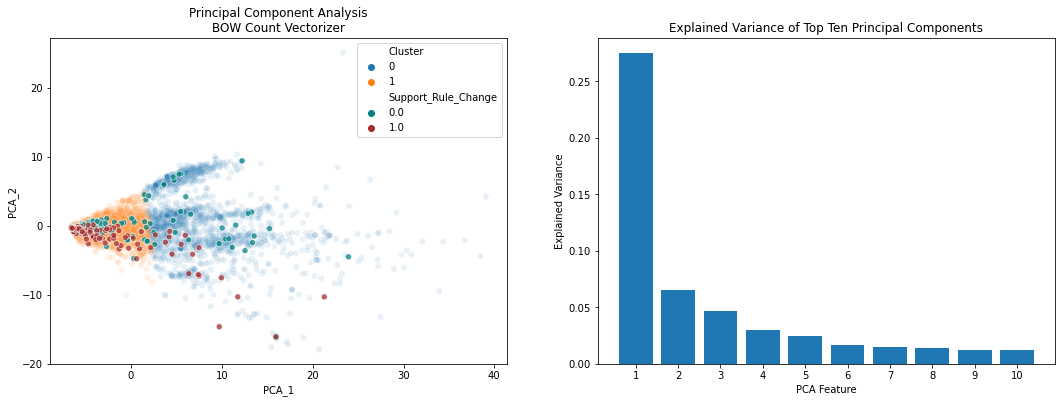

In [69]:
# Plot first two principal components and explained variance
plt.subplots(1, 2, figsize=(18, 6));
plt.subplot(1, 2, 1);
sns.scatterplot(x='PCA_1', y='PCA_2',
                data=pca_df,
                hue='Cluster',
                alpha=0.1);

sns.scatterplot(x='PCA_1', y='PCA_2',
                data=samples,
                hue='Support_Rule_Change',
                alpha=0.7,
                palette=['teal', 'brown']);

plt.title('Principal Component Analysis\n{}'
          .format('BOW Count Vectorizer' if BOW else 'WordVec Data'));

feats = range(1, 11)
plt.subplot(1, 2, 2);
plt.bar(feats, pca.explained_variance_ratio_[:10]);
plt.xticks(feats);
plt.xlabel('PCA Feature');
plt.ylabel('Explained Variance');
plt.title('Explained Variance of Top Ten Principal Components');

**Key Takeaways**

BOW Count data: The crisp boundary line evident between clusters in the PCA chart (the blue and orange-colored blobs) seems to indicate that the clustering algorithm reduced the problem in a similar manner. (The principal components were not used as features to train the KMeans algorithm). However, where the clustering splits the mass into left and right groups in the visualization, the labels are oriented in top and bottom 'stripes', with plenty of overlap in the far-left wedge. Other than pockets of same-labeled groups, this analysis shows that the clustering algorithm does not find structure and separation based on comment sentiment.

In [63]:
# TSNE cluster visualization
tsne = TSNE(n_components=2, perplexity=30)
tsne_res = tsne.fit_transform(dr_data)

In [64]:
tsne_res.shape

(6388, 2)

In [65]:
# Re-create DF with TSNE results
tsne_df = pd.DataFrame(tsne_res, columns=['TSNE_1', 'TSNE_2'], index=X_train.index)

tsne_df['Cluster'] = dr_labels

tsne_df.head()

,TSNE_1,TSNE_2,Cluster
5217,-0.007505,25.253180,1
1866,-6.869955,2.674935,1
532,-26.368446,-20.043196,1
5891,-15.701686,-17.174627,1
2514,25.620388,19.200665,0


In [66]:
# Create TSNE sample DF
tsne_samples = pd.merge(labels, tsne_df[['TSNE_1', 'TSNE_2']],
                        left_index=True,
                        right_index=True)

tsne_samples.tail(10)

,Support_Rule_Change,TSNE_1,TSNE_2
1166,1.0,-23.988449,-22.202925
8092,1.0,-38.571781,-19.629967
8160,1.0,19.279083,-34.429985
1099,1.0,-17.885677,-11.740076
2272,1.0,14.310470,-31.931997
165,1.0,-23.966393,-21.377996
488,1.0,20.359343,-20.145184
405,1.0,37.650505,-33.699875
22,1.0,-36.013889,-26.588230
8133,1.0,18.714445,-34.652756


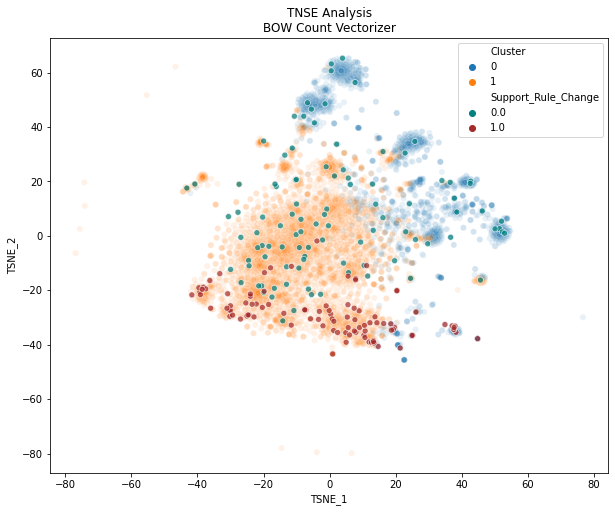

In [68]:
# Plot the TSNE results
plt.figure(figsize=(10, 8));
sns.scatterplot(x='TSNE_1', y='TSNE_2',
                data=tsne_df,
                hue='Cluster',
                alpha=0.1);

sns.scatterplot(x='TSNE_1', y='TSNE_2',
                data=tsne_samples,
                hue='Support_Rule_Change',
                alpha=0.7,
                palette=['teal', 'brown']);

plt.title('TNSE Analysis\n{}'
          .format('BOW Count Vectorizer' if BOW else 'WordVec Data'));

**Key Takeaways**

The TSNE chart also shows some underlying structure of the comments, with denser blobs that generally correspond to the actual label of the comment. There appears to be more overlap of the clustering algorithm assignments in the TSNE vs. the PCA chart, which had a crisp boundary line between the blue and orange clusters. However, both analyses clearly show the clustering algorithm didn't aptly separate the comments by sentiment.

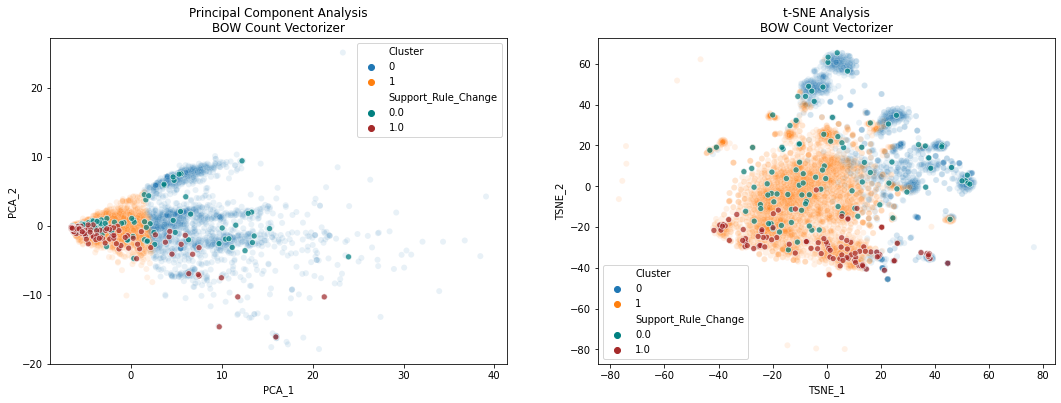

In [70]:
# Plots for presentation
SHOW_LABELS = True

plt.subplots(1, 2, figsize=(18, 6));

# Plot PCA
plt.subplot(1, 2, 1);
plt.title('Principal Component Analysis\n{}'
          .format('BOW Count Vectorizer' if BOW else 'WordVec Data'));

sns.scatterplot(x='PCA_1', y='PCA_2',
                data=pca_df,
                hue='Cluster',
                alpha=0.1);
if SHOW_LABELS:
    sns.scatterplot(x='PCA_1', y='PCA_2',
                    data=samples,
                    hue='Support_Rule_Change',
                    alpha=0.7,
                    palette=['teal', 'brown']);


# Plot TSNE
plt.subplot(1, 2, 2);
plt.title('t-SNE Analysis\n{}'
          .format('BOW Count Vectorizer' if BOW else 'WordVec Data'));

sns.scatterplot(x='TSNE_1', y='TSNE_2',
                data=tsne_df,
                hue='Cluster',
                alpha=0.1);

if SHOW_LABELS:
    sns.scatterplot(x='TSNE_1', y='TSNE_2',
                    data=tsne_samples,
                    hue='Support_Rule_Change',
                    alpha=0.7,
                    palette=['teal', 'brown']);

ext = '_Labeled' if SHOW_LABELS else ''

## <a name="sentiment-analysis"></a>Sentiment Analysis

This section will only use the labeled training and test sets, created above in `X_labeled_train`, `X_labeled_test`, `y_labeled_train`, and `y_labeled_test`. The imbalance between the classes in the dataset (~80% opposing comments vs. ~20% supportive) may cause issues. To address this, datasets using up- and down-sampling techniques to balance the classes were created, and models trained with each were compared for performance impacts. A simple Multinomial Naive Bayes classifier was selected to be the baseline model from which to compare performance.

In [71]:
# Calculate percentage of supporting vs. opposing comments
perc_sup = y_labeled_train.mean()*100

print('Supportive comments: {0:.1f}%'.format(perc_sup))
print('Opposing comments: {0:.1f}%'.format(100-perc_sup))

Supportive comments: 20.3%
Opposing comments: 79.7%


In [72]:
# Create up-sampled dataset
df_sup = support_train.copy()
df_sup['Support_Rule_Change'] = y_train[y_train == 1]
# df_sup.head()  # len: 765

df_opp = oppose_train.copy()
df_opp['Support_Rule_Change'] = y_train[y_train == 0]
df_opp.head()  # len: 195

,Comment,Support_Rule_Change
1104,Please do not support the rollback of the clea...,0.0
65,"We need to be doing more, not less, to protect...",0.0
1074,Please keep the 2015 WOTUS legislation. PLEAS...,0.0
8018,"We need to be doing more, not less, to PROTECT...",0.0
1107,"As stated, the overall objective of the CWA to...",0.0


In [73]:
# Uses support_train and oppose_train created for the word clouds
# Upsample supporting comments
sup_upsamp = resample(df_sup,
                      replace=True,
                      n_samples=len(df_opp),
                      random_state=42)

upsampled = pd.concat([sup_upsamp, df_opp])
print(upsampled.shape)

X_up_train = upsampled.drop('Support_Rule_Change', axis=1)
y_up_train = upsampled['Support_Rule_Change']
print(X_up_train.shape, y_up_train.shape)

(1530, 2)
(1530, 1) (1530,)


### Compare Performance of Different Vectorizers and Models

The following analysis compares the metrics of a survey of different models using different vectorizer methods to narrow the field of promising models. The pre-processing (vectorizing) step is done once, with the data fed into each model, versus creating pipelines for each model that include a vectorizer step. This helps to avoid redundancies in this first round of model selection.

Below, pipelines including a vectorizer step are created for each of the top three "winner's circle" models. Then a grid search is run to determine the final winning model and the hyperparameters for optimal performance.

In [74]:
# Create remaining feature vectors on up-sampled labeled data

# Count feature matrix
X_up_count = vect_count.fit_transform(X_up_train['Comment'])

# TF-IDF feature matrix
X_up_tfidf = vect_tfidf.fit_transform(X_up_train['Comment'])

# Hash w/L2 Norm feature matrix
X_up_hashL2 = vect_hash_L2.fit_transform(X_up_train['Comment'])

# Word vector feature matrix
X_up_wv = wordvec_pipe.fit_transform(X_up_train['Comment'])

/Users/heatherkusmierz/anaconda3/envs/nlp/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [75]:
up_vects = {
    'count': X_up_count,
    'tfidf': X_up_tfidf,
    'hashL2': X_up_hashL2,
    'wv': X_up_wv
}

for v in up_vects.values():
    print(v.shape)

(1530, 1974)
(1530, 1974)
(1530, 4000)
(1530, 300)


In [292]:
# Instantiate each round 1 model
round_1_mods = {
    'multiNB_count': MultinomialNB(),
    'multiNB_tfidf': MultinomialNB(),
    'compNB_count': ComplementNB(),
    'compNB_tfidf': ComplementNB(),
    'logreg_count': LogisticRegression(),
    'logreg_tfidf': LogisticRegression(),
    'logreg_hashL2': LogisticRegression(),
    'logreg_wv': LogisticRegression(),
    'linSVC_count': SVC(kernel='linear', random_state=42),
    'linSVC_tfidf': SVC(kernel='linear', random_state=42),
    'linSVC_hashL2': SVC(kernel='linear', random_state=42),
    'linSVC_wv': SVC(kernel='linear', random_state=42),
    'nlSVC_count': SVC(random_state=42),
    'nlSVC_tfidf': SVC(random_state=42),
    'nlSVC_hashL2': SVC(random_state=42),
    'nlSVC_wv': SVC(random_state=42),
    'rf_count': RandomForestClassifier(random_state=42),
    'rf_tfidf': RandomForestClassifier(random_state=42),
    'rf_hashL2': RandomForestClassifier(random_state=42),
    'rf_wv': RandomForestClassifier(random_state=42),
    'xgb_count': XGBClassifier(random_state=42),
    'xgb_tfidf': XGBClassifier(random_state=42),
    'xgb_hashL2': XGBClassifier(random_state=42),
    'xgb_wv': XGBClassifier(random_state=42)
}

In [293]:
len(round_1_mods)

24

In [295]:
# Fit each model to each feature matrix, save CV scores
cv_scores_acc = {}
cv_scores_f1 = {}

for name, model in round_1_mods.items():
    vect_to_use = name.split('_')[1]
    vect_X = up_vects[vect_to_use]
    
    s_acc = cross_val_score(model, vect_X, y_up_train, scoring='accuracy', cv=3, n_jobs=-1)
    cv_scores_acc[name] = np.mean(s_acc)
    
    s_f1 = cross_val_score(model, vect_X, y_up_train, scoring='f1', cv=3, n_jobs=-1)
    cv_scores_f1[name] = np.mean(s_f1)

In [296]:
# Compare performance
print('Model'.ljust(20), 'Accuracy\t\tF1')
print('-'*50)

for name, score in cv_scores_acc.items():
    print(name.ljust(20), '{0:.2f}%\t\t{1:.2f}%'
          .format(score*100, cv_scores_f1[name]*100))

print('-'*50)

Model                Accuracy		F1
--------------------------------------------------
multiNB_count        97.91%		97.90%
multiNB_tfidf        98.63%		98.63%
compNB_count         97.91%		97.90%
compNB_tfidf         98.63%		98.63%
logreg_count         99.02%		99.03%
logreg_tfidf         99.15%		99.15%
logreg_hashL2        97.71%		97.74%
logreg_wv            96.54%		96.61%
linSVC_count         98.63%		98.64%
linSVC_tfidf         99.80%		99.80%
linSVC_hashL2        99.02%		99.02%
linSVC_wv            97.97%		97.99%
nlSVC_count          96.54%		96.64%
nlSVC_tfidf          99.54%		99.54%
nlSVC_hashL2         99.02%		99.02%
nlSVC_wv             95.82%		95.93%
rf_count             99.41%		99.41%
rf_tfidf             99.35%		99.35%
rf_hashL2            99.08%		99.09%
rf_wv                98.30%		98.31%
xgb_count            97.91%		97.95%
xgb_tfidf            98.17%		98.20%
xgb_hashL2           98.04%		98.07%
xgb_wv               97.97%		98.01%
--------------------------------------------------


In [300]:
# Sorted accuracy scores
print('Model'.ljust(20), 'Accuracy')
print('-'*30)

for m, s in sorted(list(cv_scores_acc.items()),
                   key=lambda t: t[1],
                   reverse=True):
    print(m.ljust(20), '{0:.4f}%'.format(s*100))

print('-'*30)

Model                Accuracy
------------------------------
linSVC_tfidf         99.8039%
nlSVC_tfidf          99.5425%
rf_count             99.4118%
rf_tfidf             99.3464%
logreg_tfidf         99.1503%
rf_hashL2            99.0850%
logreg_count         99.0196%
linSVC_hashL2        99.0196%
nlSVC_hashL2         99.0196%
multiNB_tfidf        98.6275%
compNB_tfidf         98.6275%
linSVC_count         98.6275%
rf_wv                98.3007%
xgb_tfidf            98.1699%
xgb_hashL2           98.0392%
linSVC_wv            97.9739%
xgb_wv               97.9739%
multiNB_count        97.9085%
compNB_count         97.9085%
xgb_count            97.9085%
logreg_hashL2        97.7124%
logreg_wv            96.5359%
nlSVC_count          96.5359%
nlSVC_wv             95.8170%
------------------------------


In [299]:
# Sorted F1 scores
print('Model'.ljust(20), 'F1')
print('-'*30)

for m, s in sorted(list(cv_scores_f1.items()),
                   key=lambda t: t[1],
                   reverse=True):
    print(m.ljust(20), '{0:.4f}%'.format(s*100))

print('-'*30)

Model                F1
------------------------------
linSVC_tfidf         99.8043%
nlSVC_tfidf          99.5400%
rf_count             99.4147%
rf_tfidf             99.3517%
logreg_tfidf         99.1535%
rf_hashL2            99.0890%
logreg_count         99.0289%
linSVC_hashL2        99.0248%
nlSVC_hashL2         99.0192%
linSVC_count         98.6395%
multiNB_tfidf        98.6263%
compNB_tfidf         98.6263%
rf_wv                98.3083%
xgb_tfidf            98.2004%
xgb_hashL2           98.0749%
xgb_wv               98.0064%
linSVC_wv            97.9887%
xgb_count            97.9487%
multiNB_count        97.8991%
compNB_count         97.8991%
logreg_hashL2        97.7446%
nlSVC_count          96.6416%
logreg_wv            96.6061%
nlSVC_wv             95.9285%
------------------------------


There were some surprising takeaways from the round 1 model comparisons. Namely, that the XGBoost model didn't crack the top half of either metric, and second, the pre-trained word vectors didn't boost performance compared to the simpler count and TF-IDF vectorizers. In fact, the other decision tree ensemble (Random Forest) outperformed XGBoost on all vectorizers, and the top five-six scores were all based on the simpler vectorizers. The decision tree models handled the word vectors the best, which indicates that the linear models weren't the best choice to pair with that form of featurizing the data.

The next step is to tune hyperparameters of the top models - SVC, Random Forest, and Logistic Regression - and select the winner.

In [301]:
# Import SpaCy tokenizer to get around joblib pickling
#    issue when using it within GridSearchCV. Work-around source:
#    https://stackoverflow.com/questions/53885198/using-spacy-as-tokenizer-in-sklearn-pipeline
from Tokenizer.tokenizer import external_spacy_tokenizer

# Re-create stop word list
ex_tokenized_stop_words = external_spacy_tokenizer(' '.join(stop_words))

In [301]:
# Create dict to hold models
round_2_fit_models = {}

In [302]:
# Round 2: tune hyperparameters of top models and select the winner
round_2_pipelines = {
    'svc_tfidf': Pipeline([
        ('vect_tfidf', TfidfVectorizer(tokenizer=external_spacy_tokenizer,
                                       stop_words=ex_tokenized_stop_words,
                                       max_df=0.90,
                                       min_df=5)),
        ('svc', SVC(probability=True, random_state=42))
    ]),
    'rf_tfidf': Pipeline([
        ('vect_tfidf', TfidfVectorizer(tokenizer=external_spacy_tokenizer,
                                       stop_words=ex_tokenized_stop_words,
                                       max_df=0.90,
                                       min_df=5)),
        ('rf', RandomForestClassifier(random_state=42,
                                      n_jobs=-1))
    ]),
    'rf_count': Pipeline([
        ('vect_count', CountVectorizer(tokenizer=external_spacy_tokenizer,
                                       stop_words=ex_tokenized_stop_words,
                                       max_df=0.90,
                                       min_df=5)),
        ('rf', RandomForestClassifier(random_state=42,
                                      n_jobs=-1))
    ]),
    'logreg_tfidf': Pipeline([
        ('vect_tfidf', TfidfVectorizer(tokenizer=external_spacy_tokenizer,
                                       stop_words=ex_tokenized_stop_words,
                                       max_df=0.90,
                                       min_df=5)),
        ('logreg', LogisticRegression(random_state=42,
                                      n_jobs=-1))
    ]),
    'logreg_count': Pipeline([
        ('vect_count', CountVectorizer(tokenizer=external_spacy_tokenizer,
                                       stop_words=ex_tokenized_stop_words,
                                       max_df=0.90,
                                       min_df=5)),
        ('logreg', LogisticRegression(random_state=42,
                                      n_jobs=-1))
    ])
}

In [360]:
# Create hyperparameter grids
svc_parameters = {
#     'vect_tfidf__ngram_range': [(1, 1), (1, 2)],
#     'vect_tfidf__use_idf': [True, False],
    'svc__C': [0.01, 0.1, 1, 5, 10],
    'svc__kernel': ['linear', 'rbf']
}

rf_tfidf_parameters = {
#     'vect_tfidf__ngram_range': [(1, 1), (1, 2)],
#     'vect_tfidf__use_idf': [True, False],
    'rf__n_estimators': [100, 200, 300],
    'rf__max_features': ['auto', 'sqrt'],
    'rf__min_samples_leaf': [1, 3, 5]
}

rf_count_parameters = {
#     'vect_count__ngram_range': [(1, 1), (1, 2)],
    'rf__n_estimators': [100, 200, 300],
    'rf__max_features': ['auto', 'sqrt'],
    'rf__min_samples_leaf': [1, 3, 5]
}

logreg_tfidf_parameters = {
#     'vect_tfidf__ngram_range': [(1, 1), (1, 2)],
#     'vect_tfidf__use_idf': [True, False],
    'logreg__C': [0.01, 0.1, 1, 5, 10]
}

logreg_count_parameters = {
#     'vect_count__ngram_range': [(1, 1), (1, 2)],
    'logreg__C': [0.01, 0.1, 1, 5, 10]
}

In [361]:
# Store all hyperparameter grids in one dictionary for easy retrieval
hyperparameters = {
    'svc_tfidf': svc_parameters,
    'rf_tfidf': rf_tfidf_parameters,
    'rf_count': rf_count_parameters,
    'logreg_tfidf': logreg_tfidf_parameters,
    'logreg_count': logreg_count_parameters
}

In [324]:
# Run grid search on all models, save to dict
for name, pipeline in round_2_pipelines.items():
    gs_cv = GridSearchCV(pipeline, hyperparameters[name], cv=3, n_jobs=-1)
    gs_cv.fit(X_up_train['Comment'], y_up_train)
    round_2_fit_models[name] = gs_cv
    print(name, '-> DONE')

svc_tfidf -> DONE
rf_tfidf -> DONE
rf_count -> DONE
logreg_tfidf -> DONE
logreg_count -> DONE


In [442]:
# Show best scores
for name, model in round_2_fit_models.items():
    print(name, ': ', model.best_score_)

svc_tfidf :  nan
rf_tfidf :  nan
rf_count :  nan
logreg_tfidf :  nan
logreg_count :  nan


In [325]:
# Check model performance on test data
print('-'*20)

for name, model in round_2_fit_models.items():
    print(name)
    preds = model.predict(X_labeled_test['Comment'])
    print('Accuracy: {0: .4f}%'.format(metrics.accuracy_score(y_labeled_test, preds)))
    print('F1: {0: .4f}%'.format(metrics.f1_score(y_labeled_test, preds)))
    print('-'*20)

--------------------
svc_tfidf
Accuracy:  0.9667%
F1:  0.9216%
--------------------
rf_tfidf
Accuracy:  0.9583%
F1:  0.9000%
--------------------
rf_count
Accuracy:  0.9500%
F1:  0.8776%
--------------------
logreg_tfidf
Accuracy:  0.9583%
F1:  0.9038%
--------------------
logreg_count
Accuracy:  0.8542%
F1:  0.7368%
--------------------


+++++++++++++++++++++++++++++++++++++++

Even with the work-around, the spacy tokenizer doesn't work properly within sklearn's GridSearchCV. All the CV scores are `nan` and the best parameters seem to be the last run combination. The vectorizing step was pulled out and done manually in the code below, the vectorizer grid options were commented out above, and the search was run on the model hyperparameter grids only.

+++++++++++++++++++++++++++++++++++++++

In [426]:
# Create vectorizers for final models
tmp_tfidf_vect = TfidfVectorizer(tokenizer=external_spacy_tokenizer,
                                 stop_words=ex_tokenized_stop_words,
                                 max_df=0.90,
                                 min_df=5)

tmp_tfidf_X = tmp_tfidf_vect.fit_transform(X_up_train['Comment'])

tmp_count_vect = CountVectorizer(tokenizer=external_spacy_tokenizer,
                                 stop_words=ex_tokenized_stop_words,
                                 max_df=0.90,
                                 min_df=5)

tmp_count_X = tmp_count_vect.fit_transform(X_up_train['Comment'])

# Save vectorized training data
tmp_vect_train = {
    'tfidf': tmp_tfidf_X,
    'count': tmp_count_X
}

# Transform the test data
tmp_vect_test = {
    'tfidf': tmp_tfidf_vect.transform(X_labeled_test['Comment']),
    'count': tmp_count_vect.transform(X_labeled_test['Comment'])
}

In [427]:
# Set up model-only pipelines
tmp_pipelines = {
    'svc_tfidf': Pipeline([
        ('svc',SVC(probability=True, random_state=42))]),
    'rf_tfidf': Pipeline([
        ('rf',RandomForestClassifier(random_state=42,
                                     n_jobs=-1))]),
    'rf_count': Pipeline([
        ('rf', RandomForestClassifier(random_state=42,
                                      n_jobs=-1))]),
    'logreg_tfidf': Pipeline([
        ('logreg', LogisticRegression(random_state=42,
                                      n_jobs=-1))]),
    'logreg_count': Pipeline([
        ('logreg', LogisticRegression(random_state=42,
                                      n_jobs=-1))])
}

In [360]:
# Create hyperparameter grids
svc_parameters = {
#     'vect_tfidf__ngram_range': [(1, 1), (1, 2)],
#     'vect_tfidf__use_idf': [True, False],
    'svc__C': [0.01, 0.1, 1, 5, 10],
    'svc__kernel': ['linear', 'rbf']
}

rf_tfidf_parameters = {
#     'vect_tfidf__ngram_range': [(1, 1), (1, 2)],
#     'vect_tfidf__use_idf': [True, False],
    'rf__n_estimators': [100, 200, 300],
    'rf__max_features': ['auto', 'sqrt'],
    'rf__min_samples_leaf': [1, 3, 5]
}

rf_count_parameters = {
#     'vect_count__ngram_range': [(1, 1), (1, 2)],
    'rf__n_estimators': [100, 200, 300],
    'rf__max_features': ['auto', 'sqrt'],
    'rf__min_samples_leaf': [1, 3, 5]
}

logreg_tfidf_parameters = {
#     'vect_tfidf__ngram_range': [(1, 1), (1, 2)],
#     'vect_tfidf__use_idf': [True, False],
    'logreg__C': [0.01, 0.1, 1, 5, 10]
}

logreg_count_parameters = {
#     'vect_count__ngram_range': [(1, 1), (1, 2)],
    'logreg__C': [0.01, 0.1, 1, 5, 10]
}

In [428]:
# GridSearch on model parameters only
tmp_fitted = {}

for name, model in tmp_pipelines.items():
    vect_to_use = name.split('_')[1]
    vect_X = tmp_vect_train[vect_to_use]
    
    gs_cv = GridSearchCV(model, hyperparameters[name], cv=3, n_jobs=-1)
    gs_cv.fit(vect_X, y_up_train)
    tmp_fitted[name] = gs_cv
    print(name, '-> DONE')

svc_tfidf -> DONE
rf_tfidf -> DONE
rf_count -> DONE
logreg_tfidf -> DONE
logreg_count -> DONE


In [429]:
# Check best parameters per model
for name, model in tmp_fitted.items():
    print(name)
    print(model.best_score_)
    print(model.best_params_)
    print()

svc_tfidf
0.9986928104575163
{'svc__C': 5, 'svc__kernel': 'linear'}

rf_tfidf
0.9941176470588236
{'rf__max_features': 'auto', 'rf__min_samples_leaf': 1, 'rf__n_estimators': 200}

rf_count
0.9947712418300654
{'rf__max_features': 'auto', 'rf__min_samples_leaf': 1, 'rf__n_estimators': 200}

logreg_tfidf
0.9954248366013072
{'logreg__C': 5}

logreg_count
0.9901960784313726
{'logreg__C': 1}



In [430]:
print('-'*20)

for name, model in tmp_fitted.items():
    print(name)
    vect_to_use = name.split('_')[1]
    test_X = tmp_vect_test[vect_to_use]
    
    preds = model.predict(test_X)
    print('Accuracy: {0: .4f}%'.format(metrics.accuracy_score(y_labeled_test, preds)))
    print('F1: {0: .4f}%'.format(metrics.f1_score(y_labeled_test, preds)))
    print('-'*20)

--------------------
svc_tfidf
Accuracy:  0.9750%
F1:  0.9375%
--------------------
rf_tfidf
Accuracy:  0.9542%
F1:  0.8889%
--------------------
rf_count
Accuracy:  0.9500%
F1:  0.8776%
--------------------
logreg_tfidf
Accuracy:  0.9750%
F1:  0.9375%
--------------------
logreg_count
Accuracy:  0.9583%
F1:  0.9020%
--------------------


The SVC and Logistic Regression using a TF-IDF vectorizer scored exactly the same on the test set. The tie-breaker will be ROC score.

In [431]:
# Save best models
svc_contender = tmp_fitted['svc_tfidf'].best_estimator_
logreg_contender = tmp_fitted['logreg_tfidf'].best_estimator_

In [432]:
# Check SVC model predictions vs actual labels
svc_preds = svc_contender.predict(tmp_vect_test['tfidf'])
svc_pred_probs = svc_contender.predict_proba(tmp_vect_test['tfidf'])
svc_pred_probs = [p[1] for p in svc_pred_probs]

print(metrics.confusion_matrix(y_labeled_test, svc_preds))

[[189   2]
 [  4  45]]


In [433]:
# Check LogReg model predictions vs actual labels
logreg_preds = logreg_contender.predict(tmp_vect_test['tfidf'])
logreg_pred_probs = logreg_contender.predict_proba(tmp_vect_test['tfidf'])
logreg_pred_probs = [p[1] for p in logreg_pred_probs]

print(metrics.confusion_matrix(y_labeled_test, logreg_preds))

[[189   2]
 [  4  45]]


In [434]:
# Get ROC curve metrics for each model
svc_fpr, svc_tpr, svc_thresh = metrics.roc_curve(y_labeled_test,
                                                 svc_pred_probs)
svc_roc = metrics.roc_auc_score(y_labeled_test,
                                svc_pred_probs)

logreg_fpr, logreg_tpr, logreg_thresh = metrics.roc_curve(y_labeled_test,
                                                          logreg_pred_probs)
logreg_roc = metrics.roc_auc_score(y_labeled_test,
                                   logreg_pred_probs)

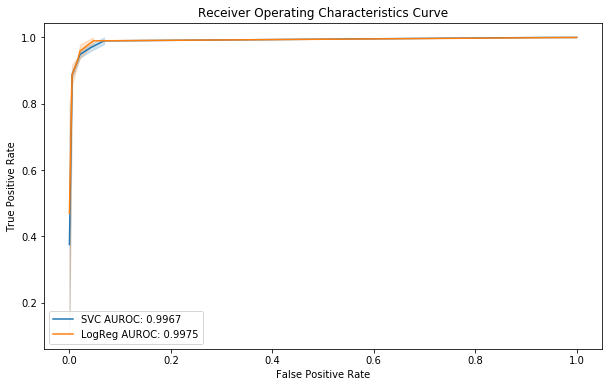

In [435]:
plt.figure(figsize=(10, 6));

sns.lineplot(x=svc_fpr, y=svc_tpr, label='SVC AUROC: {0:.4f}'
            .format(svc_roc));

sns.lineplot(x=logreg_fpr, y=logreg_tpr, label='LogReg AUROC: {0:.4f}'
            .format(logreg_roc));

plt.title('Receiver Operating Characteristics Curve');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');

In [436]:
# Create full pipeline to add pre-processing step
winner = make_pipeline(tmp_tfidf_vect,
                       logreg_contender)

In [437]:
# Test a comment
my_c = """This revision removes bodies of water that are important for pollution
    filtration, nutrient cycling, among other ecosystem services. We need to
    make sure important water resources like wetlands are protected from
    degradation!"""
print(winner.predict([my_c]))
print(winner.predict_proba([my_c]))

[0.]
[[0.93011303 0.06988697]]


In [440]:
# Save winning model
with open('final_sentiment_clf.pkl', 'wb') as f:
    pickle.dump(winner, f)

## <a name="conclusions"></a>Conclusions

A write-up of the project's conclusions is available on the [project website](https://data-science-for-conservation.github.io/WOTUS_Revision/#conclusions).